In [1]:
import math, sys
import numpy as np
import numpy.random as rd
import pandas as pd
pd.options.display.max_rows = 5

import scipy
from scipy import stats as st
from datetime import  datetime as dt
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(style="whitegrid", palette="muted", color_codes=True)

import  pickle

def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)

**準備**  
**R**  
```
install.packages("densratio")
```
**Python**  
```
pip install rpy2
```

In [2]:
import rpy2
print("rpy2 version: ", rpy2.__version__)
from rpy2.rinterface import R_VERSION_BUILD
print("R_VERSION_BUILD: ", R_VERSION_BUILD)

rpy2 version:  2.8.2
R_VERSION_BUILD:  ('3', '2.2', '', 69053)


In [3]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects.functions import SignatureTranslatedFunction

# import pandas.rpy.common as com   # [depricated]
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
densratio = importr("densratio")

In [5]:
def get_method(result, method_name):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        if i[0] == method_name:
            return i[1]

## １次元の変数

In [29]:
rd.seed(71)
n_data1 = 3000
n_data2 = 500
m = [1, 1.2]
sd = [1/8, 1/4]

x = rd.normal(loc=m[0], scale=sd[0], size=n_data1)
y = rd.normal(loc=m[1], scale=sd[1], size=n_data2)
x_y = np.r_[x, y]

# depricated
# r_x = com.convert_to_r_dataframe(pd.DataFrame(x))
# r_y = com.convert_to_r_dataframe(pd.DataFrame(y))

# PythonのデータフレームをRのデータフレームに変換！
r_x = pandas2ri.py2ri(pd.DataFrame(x))
r_y = pandas2ri.py2ri(pd.DataFrame(y))
r_x_y = pandas2ri.py2ri(pd.DataFrame(x_y))

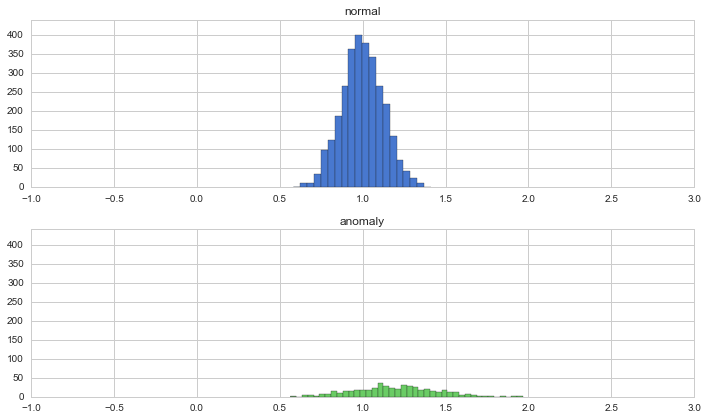

In [30]:
# 生成した人工データ（訓練データ、テストデータ）のヒストグラムを描画する
plt.figure(figsize=(10,6))
ax = plt.subplot(211)
res = plt.hist(x, bins=20, color="b")
n_max = np.max(res[0])
plt.title("normal")

plt.subplot(212, sharex=ax, sharey=ax, )
res = plt.hist(y, bins=40, color="g")
n_max = np.max(res[0]) if n_max < np.max(res[0]) else n_max
plt.title("anomaly")

plt.xlim(-1, 3)
plt.ylim(0, n_max*1.1)
plt.tight_layout()

In [31]:
# 密度比推定を実行する
result = densratio.densratio(r_x, r_y, "uLSIF",0.2, "auto") 

//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: ################## Start uLSIF ##################

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Searching optimal sigma and lambda...

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.200, lambda = 0.001, score = 10.165

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.200, lambda = 0.003, score = 0.710

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.200, lambda = 0.010, score = -0.731

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.200, lambda = 0.032, score = -0.964

 

In [32]:
type(result)

rpy2.robjects.vectors.ListVector

In [33]:
print(result.names)

[1] "alpha"                 "lambda"                "kernel_info"          
[4] "compute_density_ratio" "call"                 



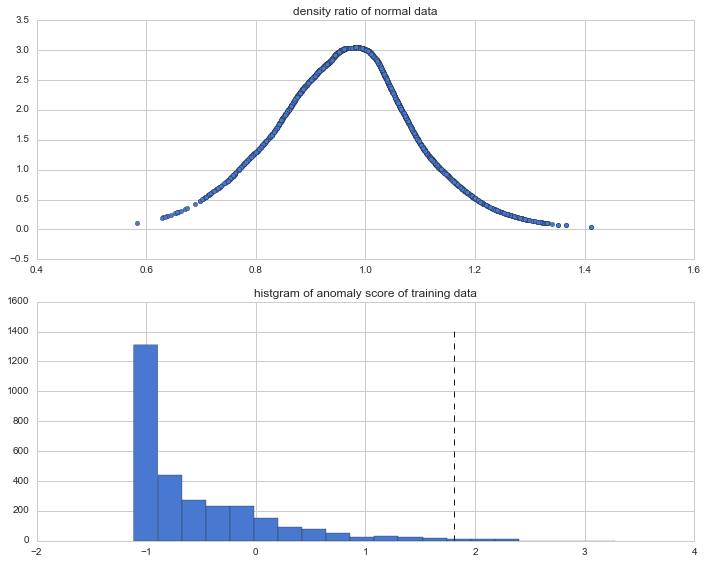

In [34]:
# 結果からcompute_density_ratioを取り出して実行。訓練データに対する推定した密度比を取得する。
compute_density_ratio = get_method(result, "compute_density_ratio")
w_hat = compute_density_ratio(r_x)

# 密度比を異常度に変換
anom_score = -np.log(w_hat)
thresh = np.percentile(anom_score, 99)    # 訓練データの密度比の99%パーセンタイルを異常を判定する閾値と設定

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.scatter(x, list(w_hat))
plt.title("density ratio of normal data")

plt.subplot(212)
res = plt.hist(anom_score, bins=20)
n_max = np.max(res[0])
plt.plot([thresh, thresh], [0, n_max*1.1], "k--", lw=1)
plt.title("histgram of anomaly score of training data")
plt.tight_layout()
plt.show()

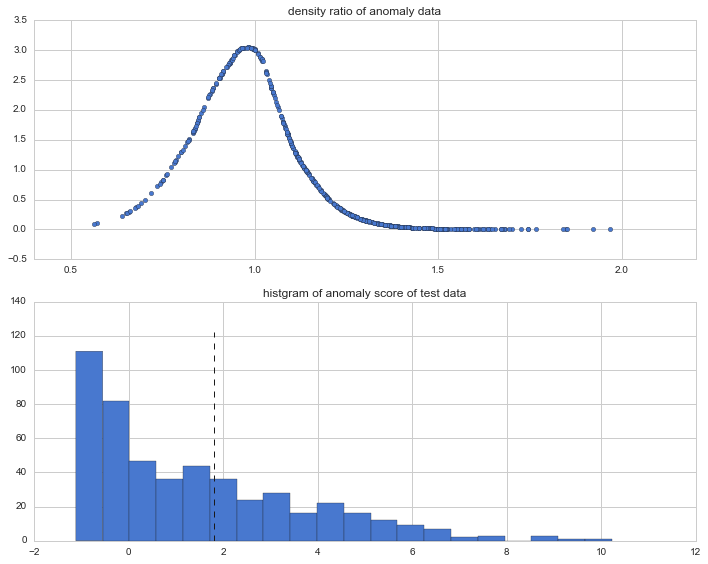

In [35]:
# 結果からcompute_density_ratioを取り出して実行。テストデータに対する推定した密度比を取得する。
compute_density_ratio = get_method(result, "compute_density_ratio")
w_hat = compute_density_ratio(r_y)
# 密度比を異常度に変換
anom_score = -np.log(w_hat)

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.scatter(y, list(w_hat))
plt.title("density ratio of anomaly data")

plt.subplot(212)
res = plt.hist(anom_score, bins=20)
n_max = np.max(res[0])
plt.plot([thresh, thresh], [0, n_max*1.1], "k--", lw=1)
plt.title("histgram of anomaly score of test data")
plt.tight_layout()
plt.show()

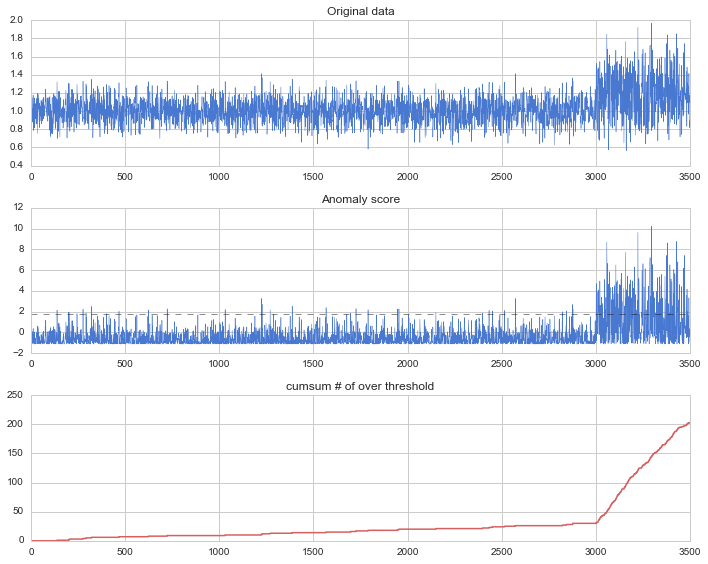

In [36]:
# 元データと異常度の関係性をグラフ化

compute_density_ratio = get_method(result, "compute_density_ratio")
w_hat = compute_density_ratio(r_x_y)
anom_score = -np.log(w_hat)

plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(x_y, lw=.5)
plt.title("Original data")

plt.subplot(312)
plt.plot(anom_score, lw=.5)
plt.plot([0,len(anom_score)], [thresh, thresh], "k--", lw=.5)
plt.title("Anomaly score")

# 閾値を超えた異常度のデータの数を積みあげたものをグラフ化
plt.subplot(313)
cumsum_anom = np.cumsum(list(map(lambda x: 1 if x > thresh else 0, anom_score)))
plt.plot(cumsum_anom, lw=1.5, color="r")
plt.title("cumsum # of over threshold")
plt.tight_layout()
plt.show()

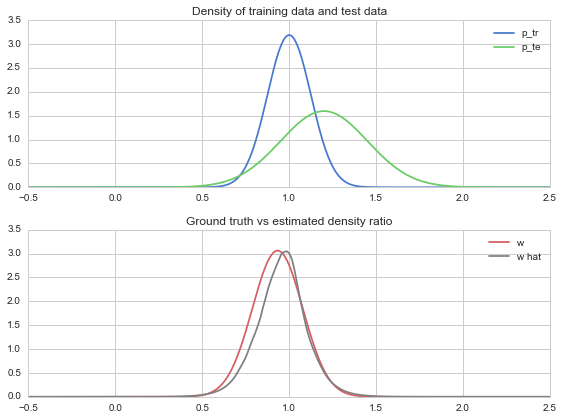

In [37]:
# Ground Truthの密度と比較するためにグラフを書いてみる
xx = np.linspace(-0.5, 2.5, 201)
y1 = st.norm.pdf(xx, loc=m[0], scale=sd[0])
y2 = st.norm.pdf(xx, loc=m[1], scale=sd[1])
y3 = (y1/y2)

r_xx = pandas2ri.py2ri(pd.DataFrame(xx))

plt.figure(figsize=(8,6))
ax = plt.subplot(211)
plt.plot(xx, y1, label="p_tr")
plt.plot(xx, y2, label="p_te")
plt.xlim(-.5, 2.5)
plt.title("Density of training data and test data")
plt.legend(loc="best")

plt.subplot(212, sharex=ax, sharey=ax, )
plt.plot(xx, y3, "r", label="w")
plt.plot(xx, compute_density_ratio(r_xx), "gray", label="w hat")
plt.legend(loc="best")
plt.title("Ground truth vs estimated density ratio")

plt.xlim(-.5, 2.5)
plt.tight_layout()

## ２次元の入力変数の場合
データは@oshokawa　さんの
https://speakerdeck.com/oshokawa/mi-du-bi-tui-ding-niyoruyi-chang-jian-zhi
を参考に作成。

In [40]:
# 訓練データの生成
rd.seed(71)

cov_n = [[ 10,  0],
         [  0, 10]]
M = 2
m_n_1 = (10, 10)
m_n_2 = (20, 20)
n_data = 500

X_norm = np.empty((2*n_data, M))
X_norm[:n_data] = st.multivariate_normal.rvs(mean=m_n_1, cov=cov_n, size=n_data)
X_norm[n_data:] = st.multivariate_normal.rvs(mean=m_n_2, cov=cov_n, size=n_data)
N_norm = 2*n_data

# テストデータの生成
cov_n_1 = [[ 5,  0],
           [  0, 5]]
cov_n_2 = [[ .1,  0],
           [  0,.1]]

m_n_1 = (12.5, 12.5)
m_n_2 = (17.5, 17.5)
m_n_3 = (15, 15)
m_n_4 = (17.5, 12.5)
m_n_5 = (12.5, 17.5)

n_data_a = 50
N_anom = 5*n_data_a
X_anomaly = np.empty((n_data_a*5, M))
for i, m, c in zip(range(5), [m_n_1,m_n_2,m_n_3,m_n_4,m_n_5], [cov_n_1,cov_n_1,cov_n_2,cov_n_1,cov_n_1]):
    X_anomaly[n_data_a*i:n_data_a*(i+1)] = st.multivariate_normal.rvs(mean=m, cov=c, size=n_data_a)

X = np.r_[X_norm, X_anomaly]

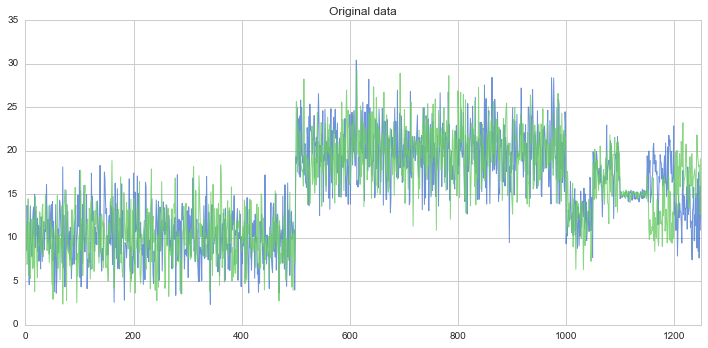

In [41]:
# データの可視化
plt.figure(figsize=(10,5))
plt.plot(X, lw=1, alpha=.8)
plt.xlim(0,len(X))
plt.title("Original data")
plt.tight_layout()
plt.show()

In [42]:
# Rのデータフレームに変換
r_x = pandas2ri.py2ri(pd.DataFrame(X_norm))
r_y = pandas2ri.py2ri(pd.DataFrame(X_anomaly))
r_xall = pandas2ri.py2ri(pd.DataFrame(X))

In [59]:
# 密度比推定を実行
result = densratio.densratio(r_x, r_y) 

//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: ################## Start uLSIF ##################

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Searching optimal sigma and lambda...

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.001, lambda = 0.001, score = 0.000

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.001, lambda = 3.162, score = -0.000

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.032, lambda = 3.162, score = -0.000

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:   sigma = 0.100, lambda = 0.001, score = -0.000

 

In [60]:
# 推定した密度比を取得する
compute_density_ratio = get_method(result, "compute_density_ratio")
w_hat = np.asanyarray(compute_density_ratio(r_xall))

In [61]:
# 異常度閾値
anom_percentile = 5 # 推定した密度比の下側5%以下を異常とする

# 訓練データのうち、指定したパーセンタイル以下を異常とする閾値を設定
w_hat_norm = w_hat[:len(X_norm)]
thresh = np.percentile(w_hat_norm, anom_percentile)

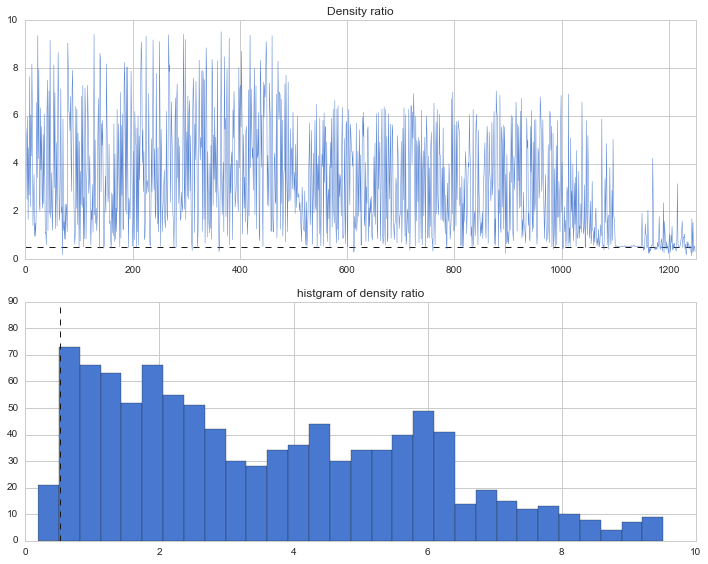

In [73]:
# 密度比をグラフ描画
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot([0, len(X)], [thresh, thresh], "k--", lw=1)
plt.plot(w_hat, lw=.5, alpha=.9)
plt.xlim(0,len(X))
plt.title("Density ratio")

# 密度比のヒストグラムを描画
plt.subplot(212)
res = plt.hist(w_hat[:len(X_norm)], bins=30)
n_max = np.max(res[0])*1.1
plt.plot([thresh, thresh], [0, n_max*1.1], "k--", lw=1)
plt.title("histgram of density ratio")
plt.tight_layout()
plt.show()

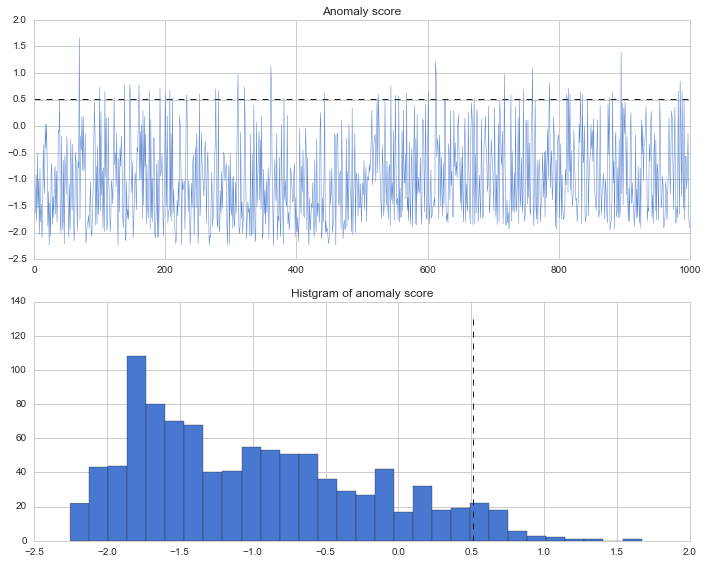

In [74]:
# 異常度の閾値を設定
anom_score = -np.log(w_hat[:len(X_norm)])
thresh = np.percentile(anom_score, 100-anom_percentile)

# 密度比をグラフ描画
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot([0, len(anom_score)], [thresh, thresh], "k--", lw=1)
plt.plot(anom_score, lw=.5, alpha=.9)
plt.xlim(0,len(anom_score))
plt.title("Anomaly score")

# 密度比のヒストグラムを描画
plt.subplot(212)
res = plt.hist(anom_score, bins=30)
n_max = np.max(res[0])*1.1
plt.plot([thresh, thresh], [0, n_max*1.1], "k--", lw=1)
plt.title("Histgram of anomaly score")
plt.tight_layout()
plt.show()

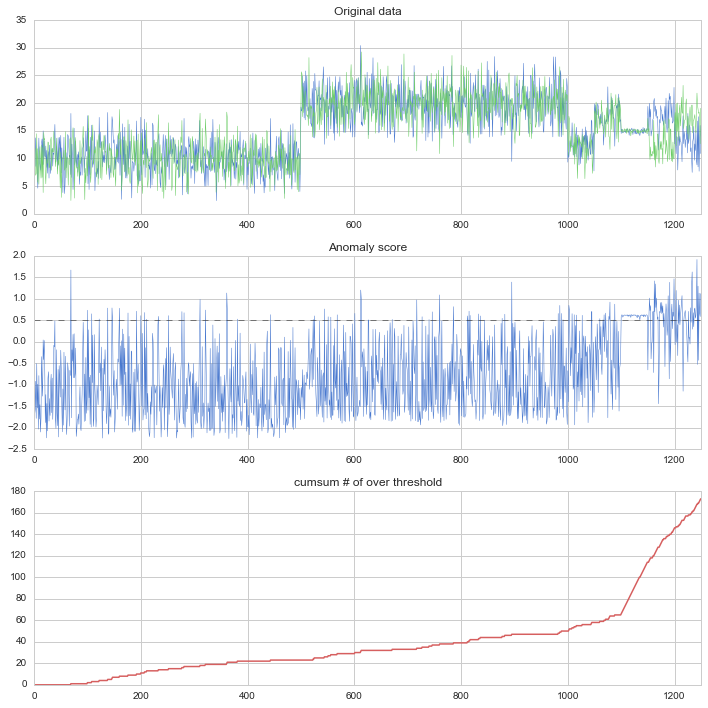

In [69]:
# 元データと異常度の関係性をグラフ化

compute_density_ratio = get_method(result, "compute_density_ratio")
w_hat = compute_density_ratio(r_xall)
anom_score = -np.log(w_hat)

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(X, lw=.5)
plt.title("Original data")
plt.xlim(0,len(X))

plt.subplot(312)
plt.plot(anom_score, lw=.5)
plt.plot([0,len(anom_score)], [thresh, thresh], "k--", lw=.5)
plt.title("Anomaly score")
plt.xlim(0,len(X))

# 閾値を超えた異常度のデータの数を積みあげたものをグラフ化
plt.subplot(313)
cumsum_anom = np.cumsum(list(map(lambda x: 1 if x > thresh else 0, anom_score)))
plt.plot(cumsum_anom, lw=1.5, color="r")
plt.title("cumsum # of over threshold")
plt.xlim(0,len(X))
plt.tight_layout()
plt.show()

### 密度可視化

In [49]:
# 密度マップ
n_grid = 201
xx = np.linspace(-5, 35, n_grid)
xxx, yyy = np.meshgrid(xx, xx)
r_grid = pandas2ri.py2ri(pd.DataFrame([xxx.flatten(), yyy.flatten()]).T)
w_hat_grid = np.asanyarray(compute_density_ratio(r_grid))

In [50]:
def density_norm(x, y):
    cov_n = [[ 10,  0],
             [  0, 10]]
    m_n_1 = (10, 10)
    m_n_2 = (20, 20)
    return (st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_1, cov=cov_n) + \
           st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_2, cov=cov_n))/2

def density_anom(x, y):
    cov_n_1 = [[ 5,  0],
               [  0, 5]]
    cov_n_2 = [[ .1,  0],
               [  0,.1]]
    m_n_1 = (12.5, 12.5)
    m_n_2 = (17.5, 17.5)
    m_n_3 = (15, 15)
    m_n_4 = (17.5, 12.5)
    m_n_5 = (12.5, 17.5)
    return (st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_1, cov=cov_n_1) + \
           st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_2, cov=cov_n_1) + \
           st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_3, cov=cov_n_2) + \
           st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_4, cov=cov_n_1) + \
           st.multivariate_normal.pdf(np.column_stack([x,y]), mean=m_n_5, cov=cov_n_1) ) / 5   

#  ground truth density
Z1 = density_norm(xxx.flatten(), yyy.flatten())
Z2 = density_anom(xxx.flatten(), yyy.flatten())

(-5, 35)

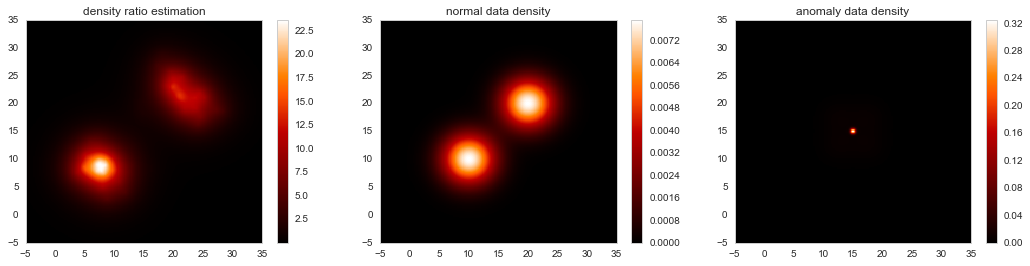

In [51]:
# Draw graphs
plt.figure(figsize=(18,4))
ax = plt.subplot(131)
ax.set_title("density ratio estimation")
plt.pcolor(xxx, yyy, w_hat_grid.reshape(xxx.shape), cmap=plt.get_cmap("gist_heat"))
plt.colorbar()
plt.xlim(-5, 35)
plt.ylim(-5, 35)

ax = plt.subplot(132)
ax.set_title("normal data density")
pc = plt.pcolor(xxx, yyy, Z1.reshape(xxx.shape), cmap=plt.get_cmap("gist_heat"))
plt.colorbar()
plt.xlim(-5, 35)
plt.ylim(-5, 35)

ax = plt.subplot(133)
ax.set_title("anomaly data density")
pc = plt.pcolor(xxx, yyy, Z2.reshape(xxx.shape), cmap=plt.get_cmap("gist_heat"))
plt.colorbar()
plt.xlim(-5, 35)
plt.ylim(-5, 35)